# Notebook Modelo 

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Sequential 
from keras.layers import Dense  
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
from collections import Counter
from keras.layers import Dropout
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pickle


## Importando datasets


#### Datasets Tratados

In [13]:
data_train = pd.read_csv('./../datasets/df_train.csv')
data_test = pd.read_csv('./../datasets/df_test.csv')

#### Datasets Normalizados

In [14]:
data_train_norm = pd.read_csv('./../datasets/train_normalize.csv')
data_test_norm = pd.read_csv('./../datasets/test_normalize.csv')

In [15]:
data_train_norm.head()

,age,education,capital_gain,capital_loss,hours_per_week,status_civic,target
0,0.301370,0.800000,0.02174,0.0,0.397959,1.0,0
1,0.452055,0.800000,0.00000,0.0,0.122449,0.0,0
2,0.287671,0.533333,0.00000,0.0,0.397959,1.0,0
3,0.493151,0.400000,0.00000,0.0,0.397959,0.0,0
4,0.150685,0.800000,0.00000,0.0,0.397959,0.0,0


### Informação Importante
O dataset de treino sofre de um desbalanceamento muito grande.
Veja o gráfico abaixo:




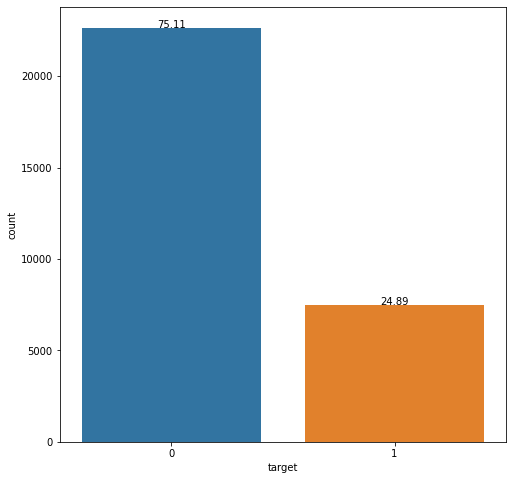

In [16]:
plt.figure(figsize=(8,8))
total = float(len(data_train) )

ax = sns.countplot(x="target", data=data_train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format((height/total)*100),ha="center") 
    
plt.show()

In [17]:
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
    ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

# Explicando o fluxo


Faremos o treinamento de cada algoritmo, para este notebook será usado Artificial Neural Network (ANN), da seguinte forma:

1. Treina-se com os datasets desbalanceados:
    - Aplicado a datasets com tratamento dos dados
    - Aplicado a  datasets com tratamento mais normalização



Em seguida escolheremos qual dataset irá prosseguir para próxima etapa, a qual tem como objetivo resolver a questão do desbalanceamento. Para isto iremos aplicar os métodos under, over sampling e a junção dos dois metódos. Os resultados, serão avaliados, dos quais iremos avaliar os seguintes paramêtros: accuracia e a recall de cada classe em especial a classe 1.

Para além disso, a matriz será um paramêtro de escolha. Pois é preferível que tenhamos mais falso positivo do que falso negativo. Isso quer dizer que, melhor classificarmos que irá ganhar menor ou igual a 50k por ano em relação a situação contrária. No entanto, vale ressaltar que não devemos esquecer a accuracia e a recall de cada classe nessa decisão.

     
     
   

# 1 Treina-se com os dataset desbalanceado:

In [18]:
def trainModel(df_train,df_test, model,result):
    X_train, X_test = df_train.drop("target", axis = 1),df_test.drop("target", axis = 1)
    y_train, y_test = df_train.target,df_test.target

    
    model.fit(X_train, y_train, epochs = 100,verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Accuracy: \n',score[1])
    print ("\nClassification Report\n")
    print (classification_report(y_test, y_pred))
    print("\n Matriz de Confusão:\n")
    plot_cm(y_test, y_pred)

#### Datasets Tratado

471/471 [==============================] - 0s 1ms/step - loss: 0.3733 - accuracy: 0.8097
Accuracy: 
 0.8096945285797119

Classification Report

              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11360
           1       0.62      0.60      0.61      3700

    accuracy                           0.81     15060
   macro avg       0.74      0.74      0.74     15060
weighted avg       0.81      0.81      0.81     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


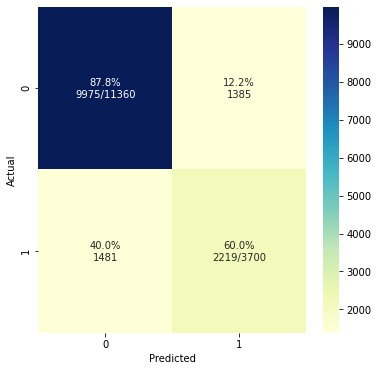

In [19]:
result = 'Dataset com tratamento dos dados.'

model = Sequential()
model.add(Dense(units = 16, input_dim = 6))
model.add(Dense(units = 16,activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

trainModel(data_train,data_test, model, result)

#### Datasets Normalizado

471/471 [==============================] - 1s 1ms/step - loss: 0.3320 - accuracy: 0.8404
Accuracy: 
 0.84037184715271

Classification Report

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     11360
           1       0.70      0.62      0.65      3700

    accuracy                           0.84     15060
   macro avg       0.79      0.76      0.78     15060
weighted avg       0.84      0.84      0.84     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


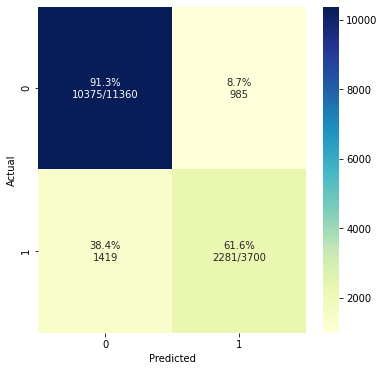

In [20]:
result = 'Dataset com tratamento dos dados e normalização.'

model2 = Sequential()
model2.add(Dense(units = 16, input_dim = 6))
model2.add(Dense(units = 16,activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

trainModel(data_train_norm,data_test_norm, model2, result)

# Comparação

|     Logistic regression| Accuracy | Precision | Precision | Recall   | Recall   | Matriz | Matriz|           
|:-----------:           |:--------:|:--------:|:---------:|:---------:|:--------:|:---------:|:--------:|
|                        |          | classe 0  | classe 1 |  classe 0 | classe 1 |  FP       | FN        
|    Dataset tratado     |  0.7964  |     0.80  |    0.73  |    0.97   | 0.27     | 0.032     | 0.731
|    Dataset normalizado |  0.8431  |     0.86  |    0.75  |    0.94   | 0.55     | 0.061     | 0.451


#### Decisão qual dataset usar :

Mediante aos resultados acima podemos ver que dataset normalizado atende aos critérios que definimos para escolher o melhor algoritmo. Desta forma, vamos adotar nos proximos modelos os datasets normalizados e concomitantemente iremos aplicar métodos para otimizar os resuldos uma vez que o dataset encontra-se desbalanceado.

Iremos adotar os seguintes métodos 

 1. **O método de Over Sampling:**

   - Aumenta-se a classe minoritária com dados sinteticos, para se igualar a classe majoritária.
   
    
2. **O método de Under Sampling:**
     
     - Diminui-se a classe  majoritária deletando dados desta, para ela se igualar a classe minoritária.
     
     
3. **O método da Equipa 9:**
    
    - Esse método é resultado da combinação dos dois métodos anteriores.



### 1 - Over Sampling

In [25]:
def trainMethodOver(df_train,df_test, model):
    X = df_train.drop("target", axis = 1)
    y = df_train.target
    smt = SMOTE()
    X, y = smt.fit_sample(X, y)
    print('Base de dados')
    ax = sns.countplot(x=y)
    X_train, X_test = X,df_test.drop("target", axis = 1)
    y_train, y_test = y,df_test.target
    
    model.fit(X_train, y_train, epochs = 100,verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Accuracy: \n',score[1])
    print ("\nClassification Report\n")
    print (classification_report(y_test, y_pred))
    print("\n Matriz de Confusão:\n")
    plot_cm(y_test, y_pred)

Base de dados
471/471 [==============================] - 0s 956us/step - loss: 0.3911 - accuracy: 0.7954
Accuracy: 
 0.7954183220863342

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.78      0.85     11360
           1       0.55      0.86      0.67      3700

    accuracy                           0.80     15060
   macro avg       0.75      0.82      0.76     15060
weighted avg       0.85      0.80      0.81     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


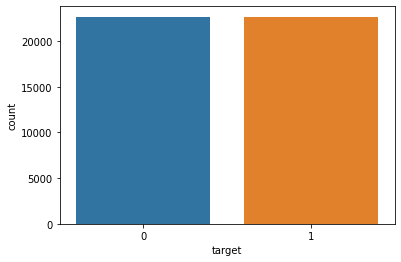

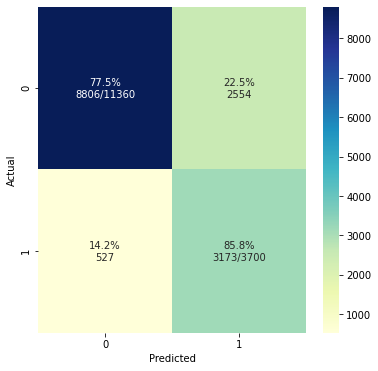

In [26]:
modelOver = Sequential()
modelOver.add(Dense(units = 16, input_dim = 6))
modelOver.add(Dense(units = 16,activation='relu'))
modelOver.add(Dense(units=1, activation='sigmoid'))
modelOver.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

trainMethodOver(data_train_norm,data_test_norm, modelOver)

A recall da classe 1 superou a classe 0, no entanto com a geração dos dados sinteticos da classe 1 podemos está produzindo um viés no modelo para classe 1. 

## 2 - Under Sampling

In [27]:
def trainMethodUnder(df_train,df_test, model):
    X = df_train.drop("target", axis = 1)
    y = df_train.target
    nr = NearMiss()
    X, y = nr.fit_sample(X, y)
    ax = sns.countplot(x=y)
    X_train, X_test = X,df_test.drop("target", axis = 1)
    y_train, y_test = y,df_test.target
    
    model.fit(X_train, y_train, epochs = 100,verbose=0)
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Accuracy: \n',score[1])
    print ("\nClassification Report\n")
    print (classification_report(y_test, y_pred))
    print("\n Matriz de Confusão:\n")
    plot_cm(y_test, y_pred)

471/471 [==============================] - 0s 811us/step - loss: 0.9081 - accuracy: 0.6640
Accuracy: 
 0.6640106439590454

Classification Report

              precision    recall  f1-score   support

           0       0.87      0.65      0.75     11360
           1       0.40      0.70      0.50      3700

    accuracy                           0.66     15060
   macro avg       0.63      0.68      0.63     15060
weighted avg       0.75      0.66      0.69     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


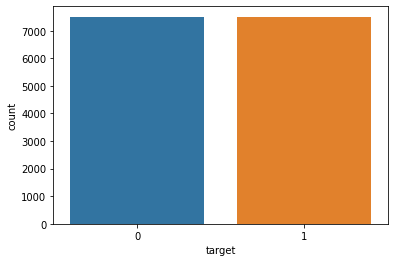

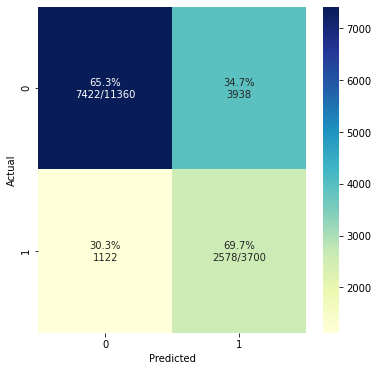

In [28]:
modelUnder = Sequential()
modelUnder.add(Dense(units = 16, input_dim = 6))
modelUnder.add(Dense(units = 16,activation='relu'))
modelUnder.add(Dense(units=1, activation='sigmoid'))
modelUnder.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

trainMethodUnder(data_train_norm,data_test_norm, modelUnder)

Parece melhor que o método anterior, houve uma melhora na classificação da classe 1 sem superar a classe 0. Com isso não mostra um viés. No entanto, podemos está perdendo muita informação pois deitamos fora mais da metade dos registos da classe 0 para se igualar a classe 1.

## 3 - Método Equipa 9

In [29]:
def trainMethodTeam(df_train,df_test, model):
    X = df_train.drop("target", axis = 1)
    y = df_train.target
    ratio= np.bincount(data_train_norm.target)
    ratiot = ratio[0]/ratio[1]
 
    
    
    
    over = SMOTE(sampling_strategy=0.5,random_state=10)
    X, y = over.fit_sample(X, y)
    under =  RandomUnderSampler(sampling_strategy=0.8)
   
    X, y = under.fit_sample(X, y)
    print(np.bincount(y))
    
    model.summary()
   
    print('Base de dados')
    ax = sns.countplot(x=y)
    X_train, X_test = X,df_test.drop("target", axis = 1)
    y_train, y_test = y,df_test.target
    
    model.fit(X_train, y_train,validation_split=0.33, epochs = 200,verbose=0)
    

    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Accuracy: \n',score[1])
    print ("\nClassification Report\n")
    print (classification_report(y_test, y_pred))
    print("\n Matriz de Confusão:\n")
    plot_cm(y_test, y_pred)

[14158 11327]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Base de dados
471/471 [==============================] - 0s 932us/step - loss: 0.3355 - accuracy: 0.8422
Accuracy: 
 0.8421646952629089

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     11360
           1       0.80      0.48      0.60      3700

    accuracy                           0.84     

<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


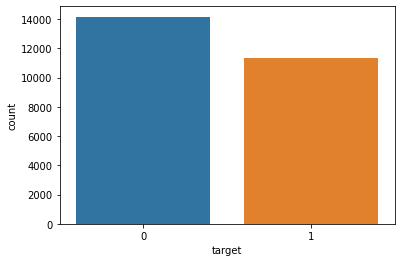

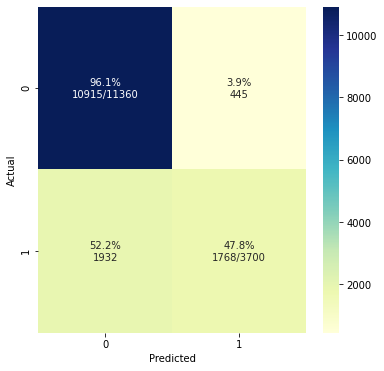

In [30]:
modelTeam = Sequential()
modelTeam = Sequential()
modelTeam.add(Dense(units = 16, input_dim = 6))
modelTeam.add(Dense(units = 16,activation='relu'))
modelTeam.add(Dense(units=1, activation='sigmoid'))
modelTeam.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
trainMethodTeam(data_train_norm,data_test_norm, modelTeam)

# Resultados

Levando em consideração a accuracia e a recall bem como outros parametros como falso positivo e falso negativo, o melhor modelo para esse algoritmo aqui testado seria o que faz uso do método over-sampling. 

No entanto, demonstra uma certo vies a classe 1. Desta forma, iremos salvar otimizar esse modelo e se esse reduzir o vies iremos guardar este. Do contrário, o modelo o qual faz uso do over-sampling será o modelo aguardado deste notebook.

In [46]:
def trainMethodOpt(df_train,df_test, model):
    X = df_train.drop("target", axis = 1)
    y = df_train.target
    smt = SMOTE()
    X, y = smt.fit_sample(X, y)
    print('Base de dados')
    ax = sns.countplot(x=y)
    X_train, X_test = X,df_test.drop("target", axis = 1)
    y_train, y_test = y,df_test.target
    
    model.fit(X_train, y_train, epochs = 200,verbose=0)
    
 
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Accuracy: \n',score[1])
    print ("\nClassification Report\n")
    print (classification_report(y_test, y_pred))
    print("\n Matriz de Confusão:\n")
    plot_cm(y_test, y_pred)

Base de dados
471/471 [==============================] - 1s 2ms/step - loss: 0.4002 - accuracy: 0.7909
Accuracy: 
 0.7909030318260193

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     11360
           1       0.55      0.82      0.66      3700

    accuracy                           0.79     15060
   macro avg       0.74      0.80      0.75     15060
weighted avg       0.84      0.79      0.80     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


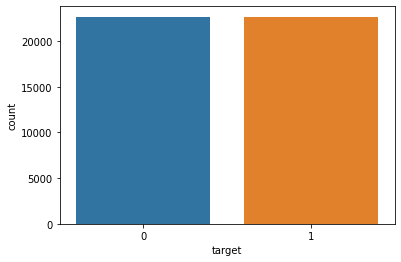

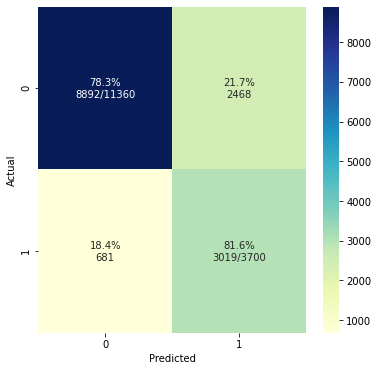

In [59]:
modelOpt = Sequential()
modelOpt.add(Dense(units = 128, input_dim = 6))
modelOpt.add(Dropout(0.2))
modelOpt.add(Dense(units = 128,activation='relu'))
modelOpt.add(Dropout(0.2))
modelOpt.add(Dense(units = 128,activation='relu'))
modelOpt.add(Dense(units=1, activation='sigmoid'))
modelOpt.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
trainMethodOpt(data_train_norm,data_test_norm,modelOpt)

#### Conclusão

Esse houve uma melhora na recall, como na accuracia e matriz de confusão desta forma o modelo otimizado será o modelo guardado deste notebook.

In [60]:
## To save model
modelOpt.save("modelANN.h5")


471/471 [==============================] - 1s 2ms/step - loss: 0.4002 - accuracy: 0.7909
Accuracy: 
 0.7909030318260193

Classification Report

              precision    recall  f1-score   support

           0       0.93      0.78      0.85     11360
           1       0.55      0.82      0.66      3700

    accuracy                           0.79     15060
   macro avg       0.74      0.80      0.75     15060
weighted avg       0.84      0.79      0.80     15060


 Matriz de Confusão:



<ipython-input-17-d4a32cf3cb7c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])
<ipython-input-17-d4a32cf3cb7c>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(['<=50K/Y', '>50K/Y'])


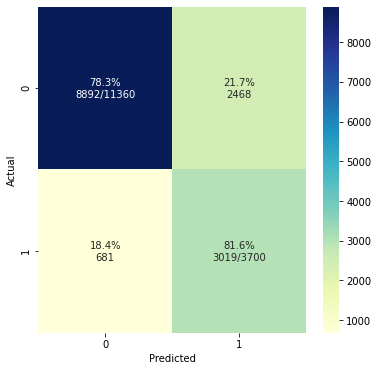

In [61]:

X_test = data_test_norm.drop("target", axis = 1)
y_test = data_test_norm.target
## To load model 
model = load_model('modelANN.h5')
## To load model IMPORT ===== from keras.models import load_model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
score = model.evaluate(X_test, y_test,verbose=1)
print('Accuracy: \n',score[1])
print ("\nClassification Report\n")
print (classification_report(y_test, y_pred))
print("\n Matriz de Confusão:\n")
plot_cm(y_test, y_pred)
